```{contents}
```
## Step Scheduler

In LangGraph, the **step scheduler** is the internal execution mechanism that determines **which node runs next, when it runs, and under what conditions**, based on the current graph structure and evolving state.
It is the core engine that transforms a static graph definition into a **dynamic, state-driven execution process**.

---

### **1. Intuition: Why a Step Scheduler Exists**

Traditional pipelines execute linearly:

```
A → B → C → End
```

LangGraph workflows are **stateful, conditional, and cyclic**:

```
A → B → C ↘
↑          D → End
└──────────┘
```

The step scheduler is responsible for:

* Interpreting the graph structure
* Tracking current execution position
* Evaluating conditions and routes
* Handling loops and parallel paths
* Enforcing safety and termination constraints

> **Mental model:**
> The step scheduler is a **deterministic state-machine engine**.

---

### **2. Core Responsibilities of the Step Scheduler**

| Responsibility       | Description                          |
| -------------------- | ------------------------------------ |
| Node selection       | Decide which node executes next      |
| State propagation    | Pass updated state between nodes     |
| Condition evaluation | Resolve conditional edges            |
| Loop handling        | Support cyclic execution             |
| Concurrency          | Manage parallel node execution       |
| Termination          | Detect and enforce stopping          |
| Safety               | Enforce recursion and timeout limits |
| Checkpointing        | Save progress between steps          |

---

### **3. Execution Lifecycle**

Each invocation of a LangGraph graph is decomposed into discrete **steps**:

```
[ Step 1 ] → Node A executes
[ Step 2 ] → State updated
[ Step 3 ] → Conditions evaluated
[ Step 4 ] → Next node selected
[ Step 5 ] → Node B executes
...
```

This continues until the scheduler reaches the `END` node or a termination rule.

---

### **4. How the Scheduler Uses State**

Every scheduling decision is driven by the **current state**.

```python
class State(TypedDict):
    counter: int
```

```python
def router(state):
    if state["counter"] < 3:
        return "loop"
    return END
```

```python
builder.add_conditional_edges("check", router, {
    "loop": "work",
    END: END
})
```

At runtime:

| Step | State     | Next Node |
| ---- | --------- | --------- |
| 1    | counter=0 | work      |
| 2    | counter=1 | work      |
| 3    | counter=2 | work      |
| 4    | counter=3 | END       |

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    counter: int

def work(state):
    return {"counter": state["counter"] + 1}

def check(state):
    return state

def route(state):
    if state["counter"] < 5:
        return "work"
    return END

builder = StateGraph(State)

builder.add_node("work", work)
builder.add_node("check", check)

builder.set_entry_point("work")
builder.add_edge("work", "check")
builder.add_conditional_edges("check", route, {"work": "work", END: END})

graph = builder.compile()

result = graph.invoke({"counter": 0})
print(result)
```

**What the scheduler does:**

```
work → check → work → check → ... → END
```

---

### **6. Scheduler Safety Controls**

| Mechanism          | Purpose                    |
| ------------------ | -------------------------- |
| `recursion_limit`  | Prevent infinite loops     |
| Timeout            | Abort long executions      |
| Error propagation  | Stop or reroute on failure |
| Checkpointing      | Resume safely              |
| Interrupt handling | Human-in-the-loop          |

```python
graph.invoke(input, config={"recursion_limit": 20})
```

---

### **7. Production Implications**

The step scheduler enables:

* **Autonomous agents**
* **Multi-step reasoning**
* **Reflection loops**
* **Self-healing systems**
* **Event-driven workflows**

Without it, LangGraph would be only a static pipeline engine.

---

### **8. Mental Model**

> **Graph structure defines what *can* happen.
> Step scheduler decides what *does* happen — one step at a time.**

This separation gives LangGraph its power:
**declarative design + imperative execution.**

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# ----- Define State -----
class State(TypedDict):
    counter: int

# ----- Nodes -----
def work(state):
    print(f"[WORK] Counter before: {state['counter']}")
    return {"counter": state["counter"] + 1}

def check(state):
    print(f"[CHECK] Counter is: {state['counter']}")
    return state

# ----- Router (Decision Logic) -----
def route(state):
    if state["counter"] < 4:
        print("[ROUTER] Continue loop\n")
        return "work"
    print("[ROUTER] Stop execution\n")
    return END

# ----- Build Graph -----
builder = StateGraph(State)

builder.add_node("work", work)
builder.add_node("check", check)

builder.set_entry_point("work")
builder.add_edge("work", "check")

builder.add_conditional_edges(
    "check",
    route,
    {"work": "work", END: END}
)

graph = builder.compile()


In [2]:
result = graph.invoke(
    {"counter": 0},
    config={"recursion_limit": 10}
)
print("\nFinal State:", result)


[WORK] Counter before: 0
[CHECK] Counter is: 1
[ROUTER] Continue loop

[WORK] Counter before: 1
[CHECK] Counter is: 2
[ROUTER] Continue loop

[WORK] Counter before: 2
[CHECK] Counter is: 3
[ROUTER] Continue loop

[WORK] Counter before: 3
[CHECK] Counter is: 4
[ROUTER] Stop execution


Final State: {'counter': 4}


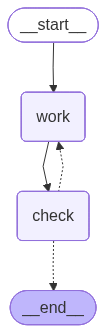

In [5]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [6]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    draft: str
    valid: bool
    attempts: int

# ----- Nodes -----

def generate(state):
    print(f"[GENERATE] Attempt {state['attempts']}")
    return {
        "draft": f"Answer v{state['attempts']}",
        "attempts": state["attempts"] + 1
    }

def validate(state):
    is_valid = state["attempts"] >= 3
    print(f"[VALIDATE] Valid? {is_valid}")
    return {"valid": is_valid}

def fix(state):
    print("[FIX] Improving answer...")
    return state

# ----- Router -----

def router(state):
    if state["valid"]:
        print("[ROUTER] Finish\n")
        return END
    print("[ROUTER] Retry\n")
    return "generate"

# ----- Build Graph -----

builder = StateGraph(State)

builder.add_node("generate", generate)
builder.add_node("validate", validate)
builder.add_node("fix", fix)

builder.set_entry_point("generate")
builder.add_edge("generate", "validate")
builder.add_edge("validate", "fix")

builder.add_conditional_edges(
    "fix",
    router,
    {"generate": "generate", END: END}
)

graph = builder.compile()


In [7]:
final = graph.invoke(
    {"draft": "", "valid": False, "attempts": 1},
    config={"recursion_limit": 10}
)
print("\nFinal State:", final)


[GENERATE] Attempt 1
[VALIDATE] Valid? False
[FIX] Improving answer...
[ROUTER] Retry

[GENERATE] Attempt 2
[VALIDATE] Valid? True
[FIX] Improving answer...
[ROUTER] Finish


Final State: {'draft': 'Answer v2', 'valid': True, 'attempts': 3}


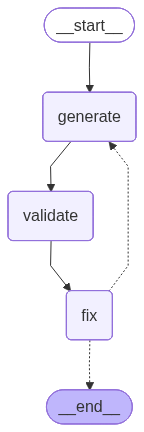

In [8]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())